# Exploratory Data Analysis (EDA)
### Capstone: Finding Incentivized Reviews

By: Peter Lee

### Imports

In [2]:
import time
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pprint import pprint
from collections import Counter
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
# Loading in the data

# random consists of the random user data
random = pd.read_csv('../Data/random_user_data.csv', sep='\t')

# top consists of the top users from amazon
top = pd.read_csv('../Data/top_reviewers_data.csv', sep='\t')

### Rating Distributions

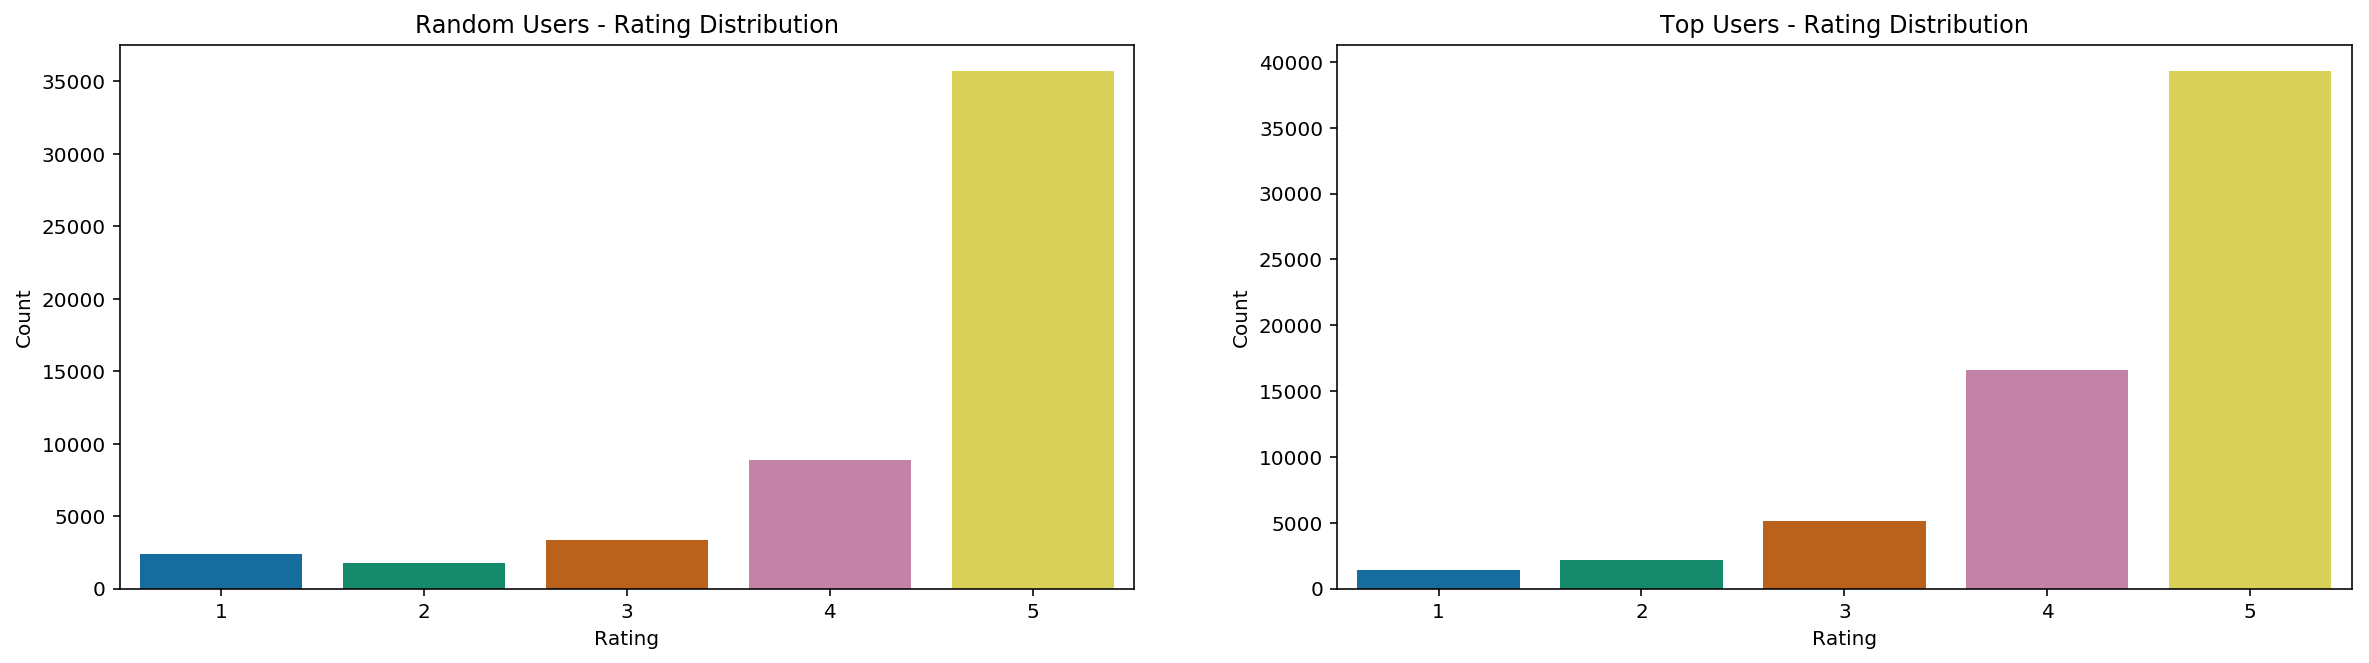

In [4]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(x='rating', data=random, palette='colorblind', ax=ax[0])
sns.countplot(x='rating', data=top, palette='colorblind', ax=ax[1])
ax[0].set_title("Random Users - Rating Distribution")
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')
ax[1].set_title("Top Users - Rating Distribution")
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Count');
plt.savefig('../Visuals/ratings_dist.png')

### Number of Reviews

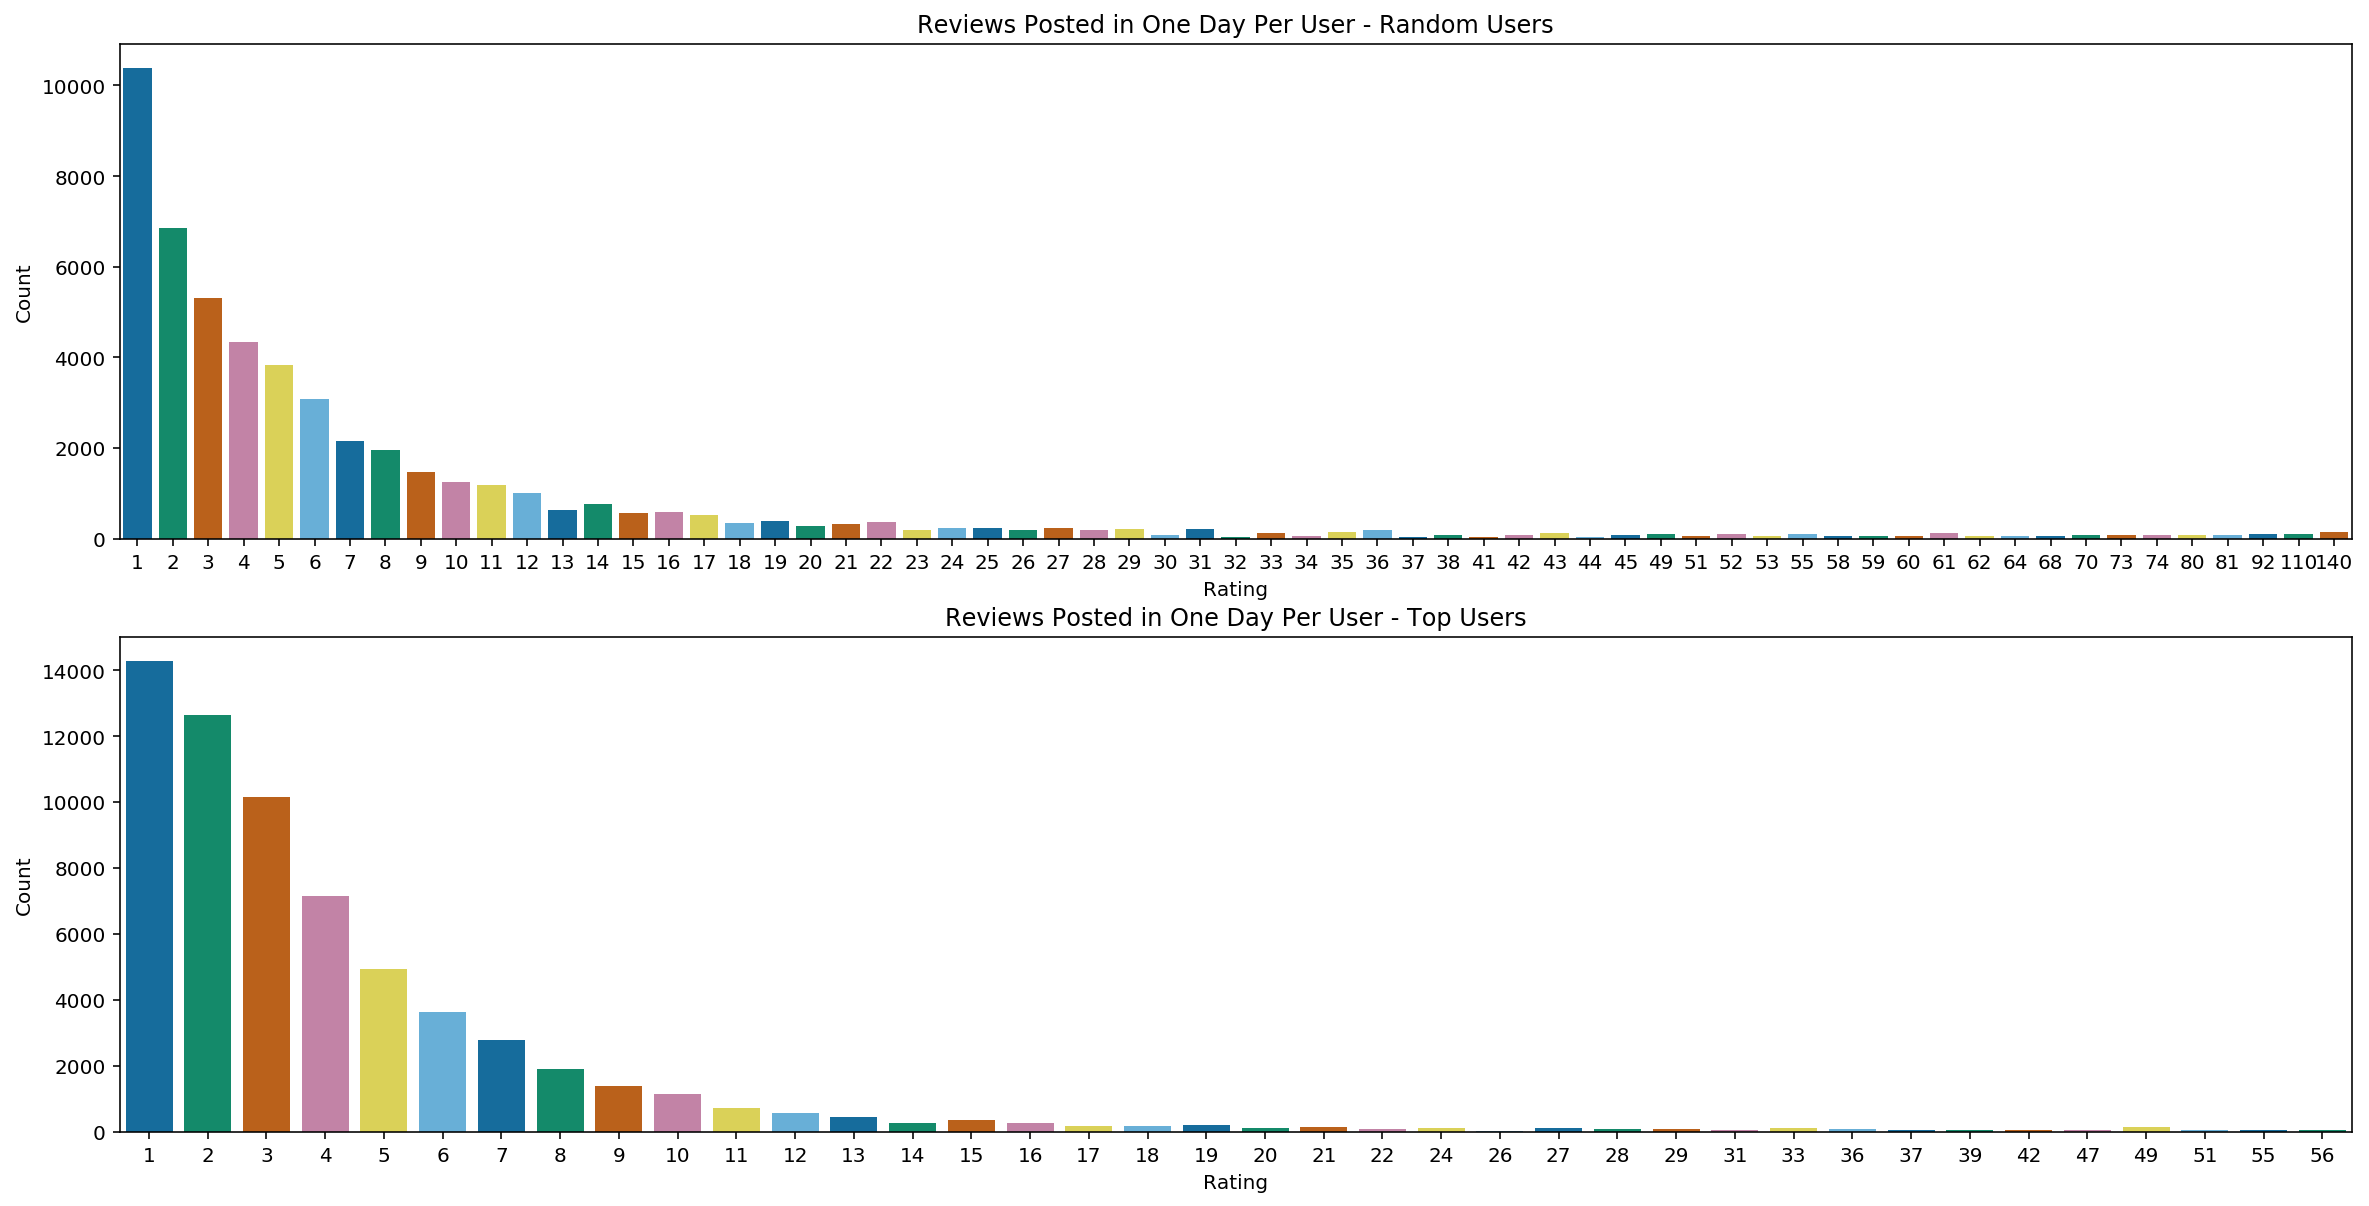

In [5]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
sns.countplot(x='1_days', data=random, palette='colorblind', ax=ax[0])
sns.countplot(x='1_days', data=top, palette='colorblind', ax=ax[1])
ax[0].set_title("Reviews Posted in One Day Per User - Random Users")
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')
ax[1].set_title("Reviews Posted in One Day Per User - Top Users")
ax[1].set_xlabel('Rating')
ax[1].set_ylabel('Count');
plt.savefig('../Visuals/one_day_dist.png')

Users with 60 or more reviews within a day will be flagged as potentially incentivized.

In [6]:
flagged = list(random[random['1_days'] > 59].author_ID.unique())

In [7]:
flagged

['AEHLQLICVWFWNV3ZJJP6HY2F6DPA',
 'AEVPXPW662NKOPTJMJ4YOZ2VF2OQ',
 'AHUZN6NHSH3BO5LEVZDJBRXKPGSQ',
 'AEKMF6ISG5NXUZZV7QVOZ4HNQNTA',
 'AGTVLGS7QJSZDLVYVZNBLV6FF2IA',
 'AEOXYXPBT3Z46ELCZKWHWUVYYPAA',
 'AHSJF4CXDXNNMN7YSWIGTI6A3FBQ',
 'AESLS35BUMHBJB4MYJ2GJ3VCPZGA',
 'AEL7VI4MMQIJUF6QCKZ36YQCIKRA',
 'AFUGTHCRANA4WRLQEIRAXSLLKUHQ',
 'AGUHTMJIE347W2VOINBJ45KGD2DQ',
 'AFKXE6CDKQOH7WPGLVWADMU2KXOQ']

### Text Lengths

In [8]:
# Creating 2 new columns in each dataframe based on text length
random['title_len'] = random.title.map(lambda x: len(x))
random['review_len'] = random.review.map(lambda x: len(x))

top['title_len'] = top.title.map(lambda x: len(x))
top['review_len'] = top.review.map(lambda x: len(x))

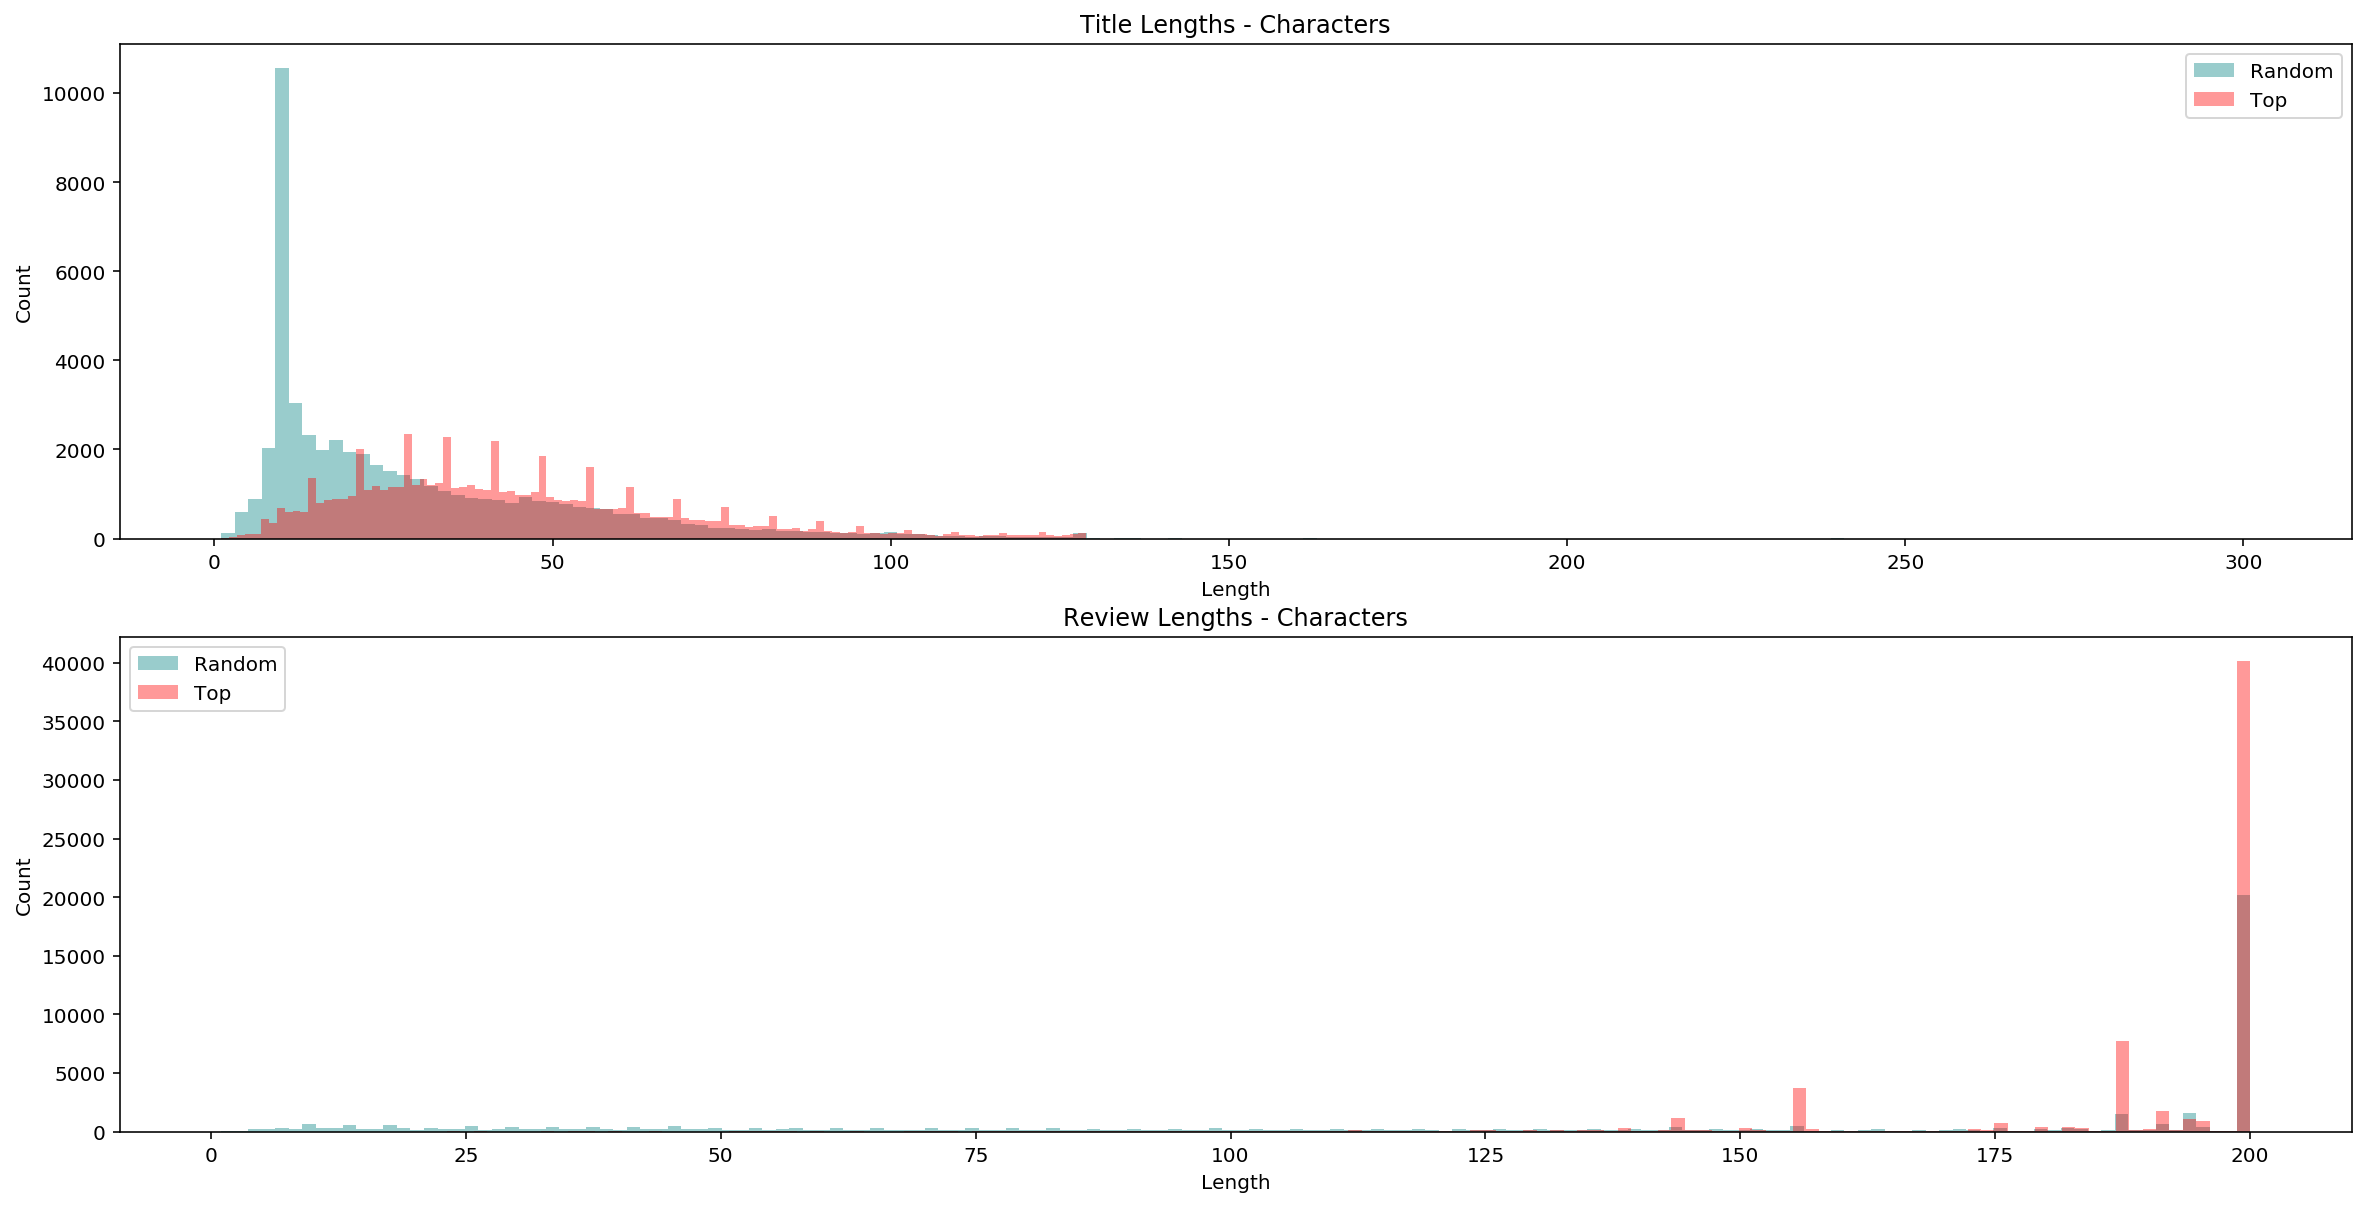

In [9]:
fig, ax = plt.subplots(2,1,figsize=(20,10))
sns.distplot(random.title_len, kde=False, bins=150, color='teal', ax=ax[0])
sns.distplot(top.title_len, kde=False, bins=150, color='red', ax=ax[0])
sns.distplot(random.review_len, kde=False, bins=150, color='teal', ax=ax[1])
sns.distplot(top.review_len, kde=False, bins=150, color='red', ax=ax[1])
ax[0].set_title("Title Lengths - Characters")
ax[0].set_xlabel('Length')
ax[0].set_ylabel('Count')
ax[0].legend(['Random', 'Top'],loc="best");
ax[1].set_title("Review Lengths - Characters")
ax[1].set_xlabel('Length')
ax[1].set_ylabel('Count')
ax[1].legend(['Random', 'Top'],loc="best");
plt.savefig('../Visuals/title_len_dist.png')

Flagging users with review lengths of 100 or less characters at least 50 or more times. 84 unique users flagged out of 1080 users.

In [10]:
flagged_1 = list(random[random.title.isin(['Five Stars', 'Four Stars', 'Three Stars', 'Two Stars', 'One Star'])].author_ID.value_counts()[random[random.title.isin(['Five Stars', 'Four Stars', 'Three Stars', 'Two Stars', 'One Star'])].author_ID.value_counts()>49].index)

In [11]:
len(flagged_1)

37

In [12]:
flagged_2 = list(random[random.review_len < 101].author_ID.value_counts()[random[random.review_len < 101].author_ID.value_counts() > 49].index)

In [13]:
len(flagged_2)

84

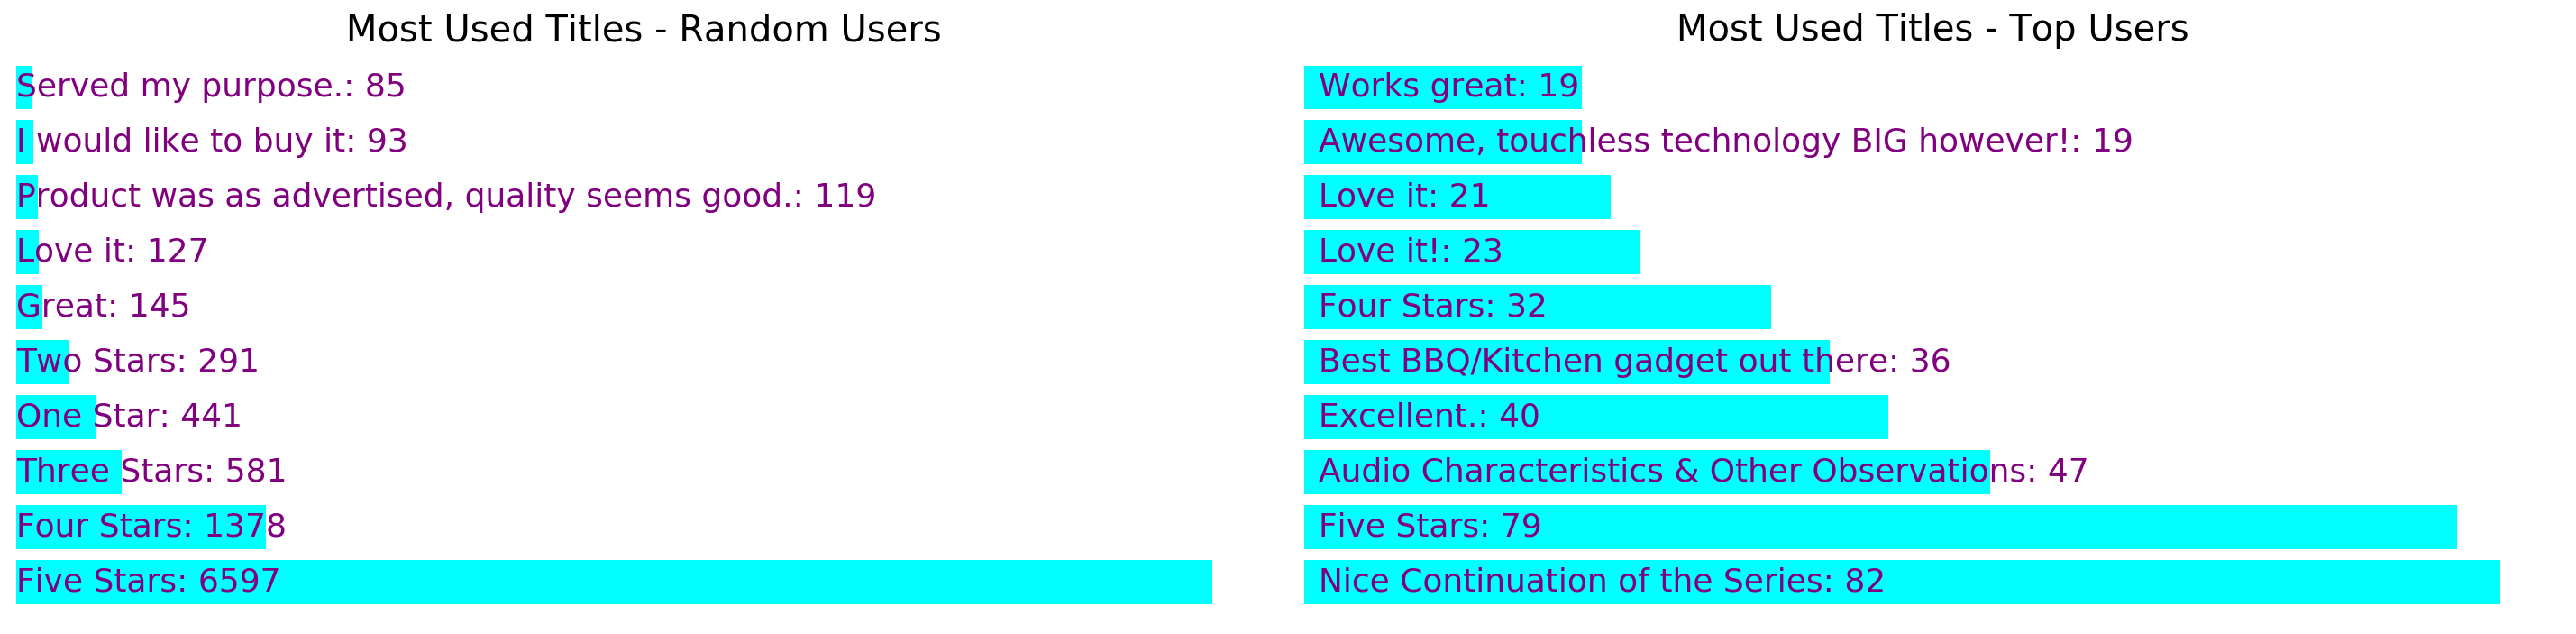

In [15]:
fig, ax = plt.subplots(1,2,figsize=(20,5))
df = pd.DataFrame(top.title.value_counts().head(10))
df.plot(kind="barh", legend=False, width=0.8, colormap='cool', ax=ax[1])
for i, (p, pr) in enumerate(zip(df.index, df["title"])):
    ax[1].text(s=p + ': ' + str(pr), x=1, y=i, color="Purple", verticalalignment="center", size=18)
ax[1].axis("off")
# xticks & yticks have empty lists to reduce white space in plot
ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Most Used Titles - Top Users', size=20)

df2 = pd.DataFrame(random.title.value_counts().head(10))
df2.plot(kind="barh", legend=False, width=0.8, colormap='cool', ax=ax[0])
for i, (p, pr) in enumerate(zip(df2.index, df2["title"])):
    ax[0].text(s=p + ': ' + str(pr), x=1, y=i, color="Purple", verticalalignment="center", size=18)
ax[0].axis("off")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Most Used Titles - Random Users', size=20)


plt.tight_layout()

plt.savefig('../Visuals/titles_most_used.png')

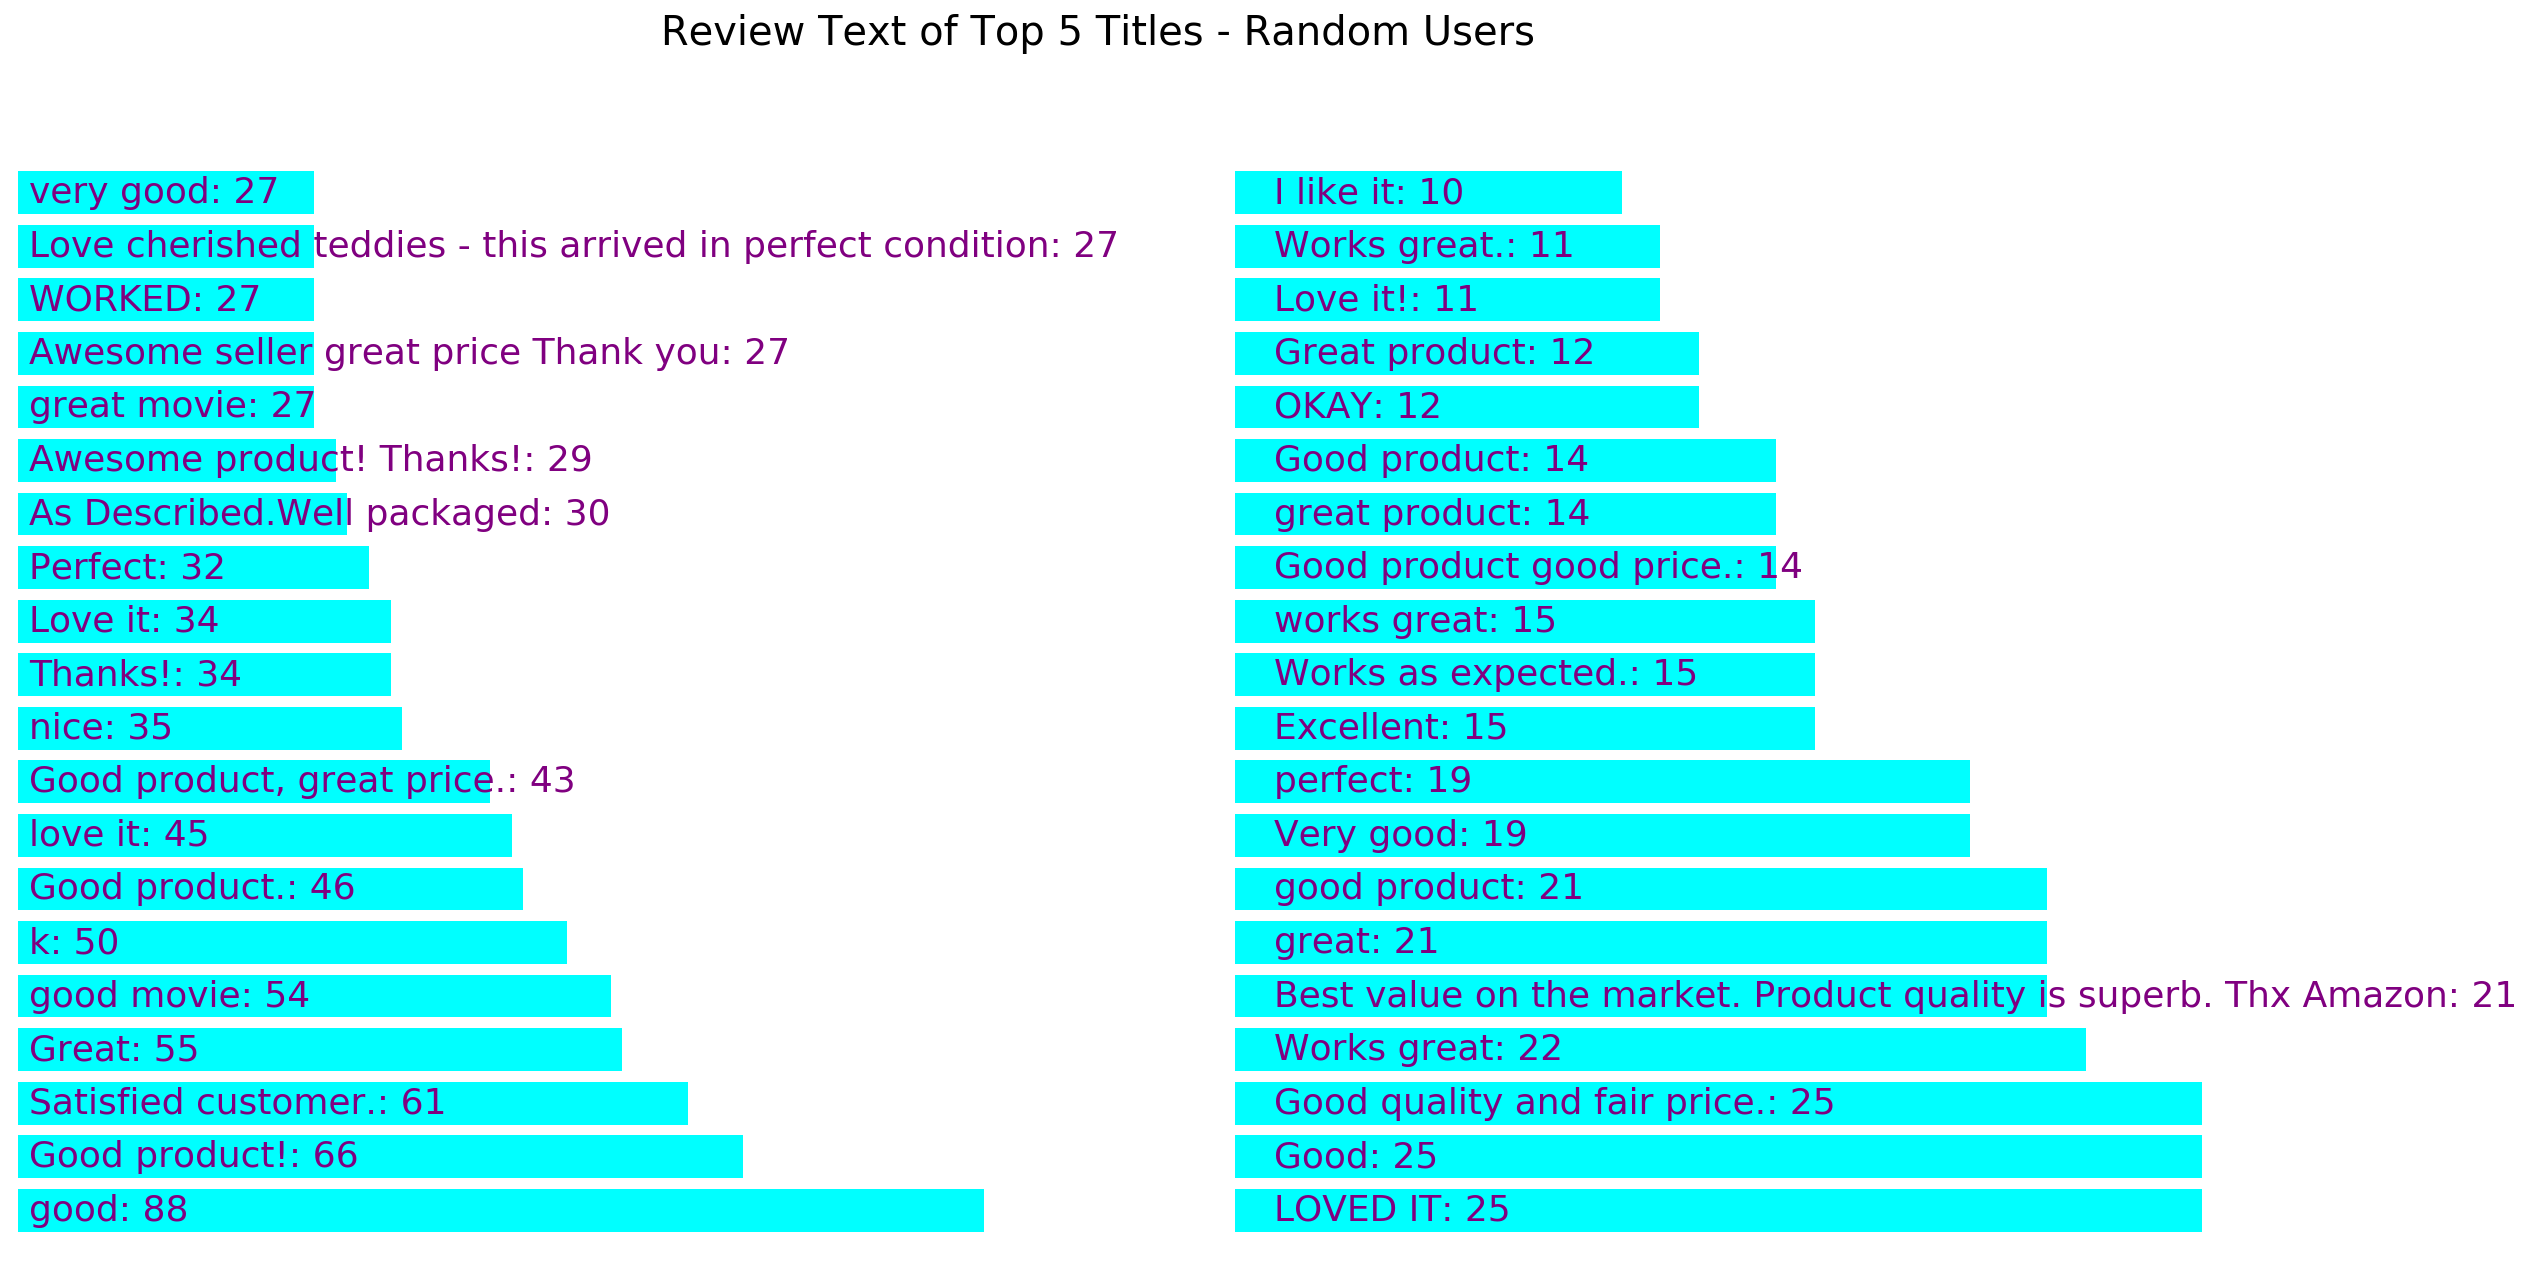

In [16]:
fig, ax = plt.subplots(1,2,figsize=(20,10))
review_stars = pd.DataFrame(random[random.title.isin(['Five Stars', 'Four Stars', 'Three Stars', 'Two Stars', 'One Star'])].review.value_counts().head(40))
review_stars[:20].plot(kind="barh", legend=False, width=0.8, colormap='cool', ax=ax[0])
for i, (p, pr) in enumerate(zip(review_stars[:20].index, review_stars[:20]["review"])):
    ax[0].text(s=p + ': ' + str(pr), x=1, y=i, color="Purple", verticalalignment="center", size=18)
ax[0].axis("off")
# xticks & yticks have empty lists to reduce white space in plot
ax[0].set_xticks([])
ax[0].set_yticks([])

review_stars[20:].plot(kind="barh", legend=False, width=0.8, colormap='cool', ax=ax[1])
for i, (p, pr) in enumerate(zip(review_stars[20:].index, review_stars[20:]["review"])):
    ax[1].text(s=p + ': ' + str(pr), x=1, y=i, color="Purple", verticalalignment="center", size=18)
ax[1].axis("off")
# xticks & yticks have empty lists to reduce white space in plot
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.suptitle('Review Text of Top 5 Titles - Random Users', fontsize=20);

plt.savefig('../Visuals/most_used_titles_reviews_body.png')

Flagging the users who used the top 40 most common review text 10 or more times. 20 unique users flagged.

In [17]:
random[random.review.isin(review_stars.index)].author_ID.value_counts()[random[random.review.isin(review_stars.index)].author_ID.value_counts() > 10]

AGUHTMJIE347W2VOINBJ45KGD2DQ    250
AGJBLM6O43DUUTQI52GRVVR6YDFA    103
AHZJBE7VHDBTUIHU5NQZAO34JUWQ     83
AEL7VI4MMQIJUF6QCKZ36YQCIKRA     64
AFUMFROHVGIFLYBSWPQRTYODDH2A     63
AGY6FH53SDSX45CMVXQU7VJJZ3YA     60
AEQQ64WXEJWEPSUHLCGROLMWFTWA     56
AF6YBMMQLES4IHKSPRKBX7UASQWA     38
AGDHPPXM3N2IUTP2NSZHOHZAFJ7A     30
AEVR6S6RCFZNXJHPOGO5LIAJLIOQ     28
AEHADTEMKFBQBAZH7CJ44F2IKUFA     27
AGXMTOTV7TKJ4765W7T552WO5UMA     24
AFR42HISOEORFOBZHY3XF6FKGBBQ     18
AFWFD7Y7JMCIX6SADUNV2M6STMGA     15
AFJJC6E3LET3LUENK5BTKLOIR6TA     14
AF6Q2NCLC7RBSS5US3GJSTJBBKZQ     14
AEZJDH5TKRMEZZXSFJU7JFOKXM5A     13
AHOQTA6YSUGSTOPTWVAV2VZSHC6Q     13
AGKQPW635KKUHISADJFXOY5KFMNQ     12
AHDI46HN24IZ4NX27XTE4ED4QLCQ     12
Name: author_ID, dtype: int64

In [18]:
flagged_3 = list(random[random.review.isin(review_stars.index)].author_ID.value_counts()[random[random.review.isin(review_stars.index)].author_ID.value_counts() > 10].index)

In [357]:
flagged

['AEHLQLICVWFWNV3ZJJP6HY2F6DPA',
 'AEVPXPW662NKOPTJMJ4YOZ2VF2OQ',
 'AHUZN6NHSH3BO5LEVZDJBRXKPGSQ',
 'AEKMF6ISG5NXUZZV7QVOZ4HNQNTA',
 'AGTVLGS7QJSZDLVYVZNBLV6FF2IA',
 'AEOXYXPBT3Z46ELCZKWHWUVYYPAA',
 'AHSJF4CXDXNNMN7YSWIGTI6A3FBQ',
 'AESLS35BUMHBJB4MYJ2GJ3VCPZGA',
 'AEL7VI4MMQIJUF6QCKZ36YQCIKRA',
 'AFUGTHCRANA4WRLQEIRAXSLLKUHQ',
 'AGUHTMJIE347W2VOINBJ45KGD2DQ',
 'AFKXE6CDKQOH7WPGLVWADMU2KXOQ']

In [19]:
len(flagged_3)

20

In [20]:
# fitting and transforming CV on democratic tweets
cv = CountVectorizer(ngram_range=(2,2))
cv.fit(random['title'])
cv_bigrams = cv.transform(random['title'])

# Creating a dataframe containing bigram frequency
frequencies = sum(cv_bigrams).toarray()[0]
cv_bigram_df = pd.DataFrame(frequencies, index=cv.get_feature_names(), 
                             columns=['count'])

cv_bigram_df.index.rename('review', inplace=True)
cv_top_dem = pd.DataFrame(cv_bigram_df.sort_values('count', ascending=False).head(10)).reset_index()
cv_top_dem

,review,count
0,five stars,6620
1,four stars,1385
2,easy to,905
3,this is,829
4,love this,800
5,for the,784
6,love it,739
7,great for,598
8,three stars,583
9,it is,556


In [23]:
aa = flagged + flagged_1 + flagged_2 + flagged_3 + flagged_4
len(np.unique(aa))

94

In [24]:
len(aa)

162

In [34]:
holder = []
for each in aa:
    result = {}
    result['id'] = each
    result['count'] = aa.count(each)
    holder.append(result)
bb = pd.DataFrame(holder, )

In [36]:
bb.id.value_counts()

AGUHTMJIE347W2VOINBJ45KGD2DQ    5
AEL7VI4MMQIJUF6QCKZ36YQCIKRA    4
AEKMF6ISG5NXUZZV7QVOZ4HNQNTA    3
AEVR6S6RCFZNXJHPOGO5LIAJLIOQ    3
AGY6FH53SDSX45CMVXQU7VJJZ3YA    3
AGJBLM6O43DUUTQI52GRVVR6YDFA    3
AHSJF4CXDXNNMN7YSWIGTI6A3FBQ    3
AEVPXPW662NKOPTJMJ4YOZ2VF2OQ    3
AFJJC6E3LET3LUENK5BTKLOIR6TA    3
AEOXYXPBT3Z46ELCZKWHWUVYYPAA    3
AHEXPV2WAD7TYBXIB65I7JIDQSAA    3
AESLS35BUMHBJB4MYJ2GJ3VCPZGA    3
AFUGTHCRANA4WRLQEIRAXSLLKUHQ    3
AHZJBE7VHDBTUIHU5NQZAO34JUWQ    3
AEZJDH5TKRMEZZXSFJU7JFOKXM5A    3
AFR42HISOEORFOBZHY3XF6FKGBBQ    3
AF6YBMMQLES4IHKSPRKBX7UASQWA    3
AFUMFROHVGIFLYBSWPQRTYODDH2A    3
AEQQ64WXEJWEPSUHLCGROLMWFTWA    3
AHUYKCKQOVTFGWWTTXUSCK4HDSYA    2
AG2HO6RIMENBRSKOH4R7YMX4D2WA    2
AFVHCS2UDHADGFD26VDKMCBS3X5A    2
AEYY6OGMIE6B7H6AVAFD57U2B7UQ    2
AFKXE6CDKQOH7WPGLVWADMU2KXOQ    2
AF2CHITNQ3UQZTSMSMRZZRSQGFLA    2
AGGANWIDB5YTXRG6NI3YER7VV6XA    2
AFK2LSARPZ4JBGZRIRYOLP47QZTA    2
AEGXGRHGPC4UKMCNHGNJS42WPIRQ    2
AGGRTEXKAA4X734VXDFZGM7QJFWA    2
AEFESC7JDYPUY6

Users using the title as the review more than 10 times

In [22]:
flagged_4 = list(random[random.title == random.review].author_ID.value_counts()[random[random.title == random.review].author_ID.value_counts()>10].index)

In [410]:
bb = np.unique(aa)

In [411]:
dd = random.copy()

In [412]:
dd['fakes'] = dd.author_ID.map(lambda x: 1 if x in bb else 0)

In [415]:
dd[dd.fakes == 1]

,date,rating,review,title,url_author,author_ID,rating_avg,review_num,history_length,max,...,1_days,2_days,3_days,7_days,21_days,30_days,14_days,title_len,review_len,fakes
542,2018-03-31,5,very good earbuds ，is more convinced when i ca...,very good earbuds ，is more convinced when i ca...,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,5,5,5,5,15,25,6,64,140,1
543,2018-03-31,5,very good quality，front cover and back cover f...,Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,5,5,5,5,15,25,6,10,92,1
544,2018-03-31,5,easy to install，lcd screen works great！save a ...,Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,5,5,5,5,15,25,6,10,82,1
545,2018-03-31,5,i use this for nintendo new 3ds，it charges ver...,Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,5,5,5,5,15,25,6,10,74,1
546,2018-03-31,5,it is samll so will not distract while i am dr...,... so will not distract while i am driving。it...,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,5,5,5,5,15,25,6,106,150,1
547,2018-03-22,5,i got it when it was raining days，i am so happ...,... got it when it was raining days，i am so ha...,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,1,1,1,1,20,22,10,100,98,1
548,2018-03-12,5,"like this blanket,good for pinic and camping,b...",Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,3,3,9,18,21,21,19,10,56,1
549,2018-03-12,5,looks good ，i put it in car ，office，i can char...,Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,3,3,9,18,21,21,19,10,61,1
550,2018-03-12,5,"a useful set for outside and emergency,good qu...",Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,3,3,9,18,21,21,19,10,61,1
551,2018-03-10,5,like this case，fit the phone perfectly and can...,Five Stars,https://www.amazon.com/gp/profile/amzn1.accoun...,AHY5UZB3YDMRYIGTFPCPILCKIM4A,5.000000,83,301 days 00:00:00.000000000,2018-03-31,...,6,6,8,15,18,20,16,10,74,1


In [416]:
dd.fakes.value_counts()

0    35804
1    16231
Name: fakes, dtype: int64

In [417]:
fake = dd[dd.fakes == 1]

In [418]:
real = dd[dd.fakes == 0]

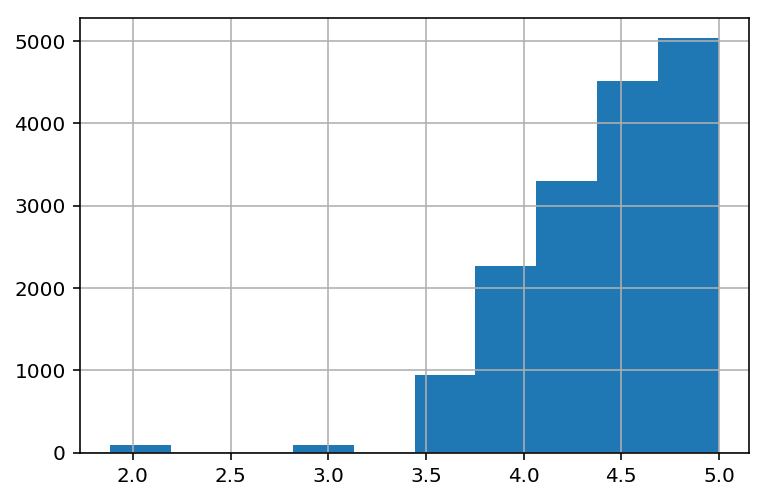

In [421]:
fake.title

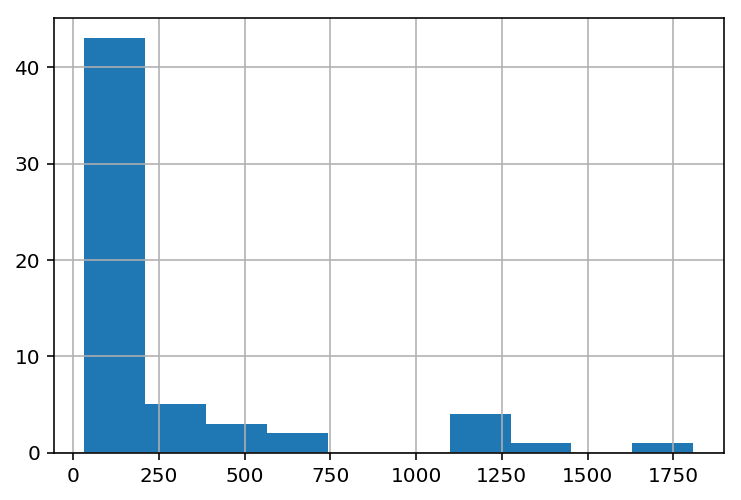

In [425]:
fake['1_days'].value_counts().hist()

In [426]:
new = random.copy()

In [427]:
new

,date,rating,review,title,url_author,author_ID,rating_avg,review_num,history_length,max,...,review_freq,1_days,2_days,3_days,7_days,21_days,30_days,14_days,title_len,review_len
0,2018-04-03,5,I love the design of these perfume spray bottl...,Easy to grip,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,1,3,3,4,16,24,14,12,200
1,2018-04-02,2,The rope is too long for me. I had to take off...,The handles are too skinny to have an easy gri...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,2,2,2,4,16,23,13,84,200
2,2018-04-02,4,This steamer is convenient to use. It fits snu...,It is easy to fold in and to spread out,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,2,2,2,4,16,23,13,39,200
3,2018-03-29,5,The coffee presser is very easy to use to make...,The coffee presser is very easy to use to make...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,1,1,2,8,21,21,13,53,200
4,2018-03-27,5,These lace flat socks fit perfectly. The flat ...,I love how they do not show when I wear my ...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,1,1,6,10,20,20,12,46,200
5,2018-03-25,5,The case fits the phone perfectly. The case do...,I definitely love how the case has a soft and ...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,5,5,6,9,19,19,12,64,200
6,2018-03-25,5,I have flat feet and occasionally my feet hurt...,These arch support inserts are comfortable and...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,5,5,6,9,19,19,12,68,200
7,2018-03-25,4,The meat injector is on the heavy side. The ne...,And the injector is easy to clean,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,5,5,6,9,19,19,12,33,200
8,2018-03-25,5,The power strip has a long enough wire in orde...,I like how the power strip is not bulky,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,5,5,6,9,19,19,12,39,200
9,2018-03-25,5,This hand strengthener workout kit has various...,I also like how there are five different hand ...,https://www.amazon.com/gp/profile/amzn1.accoun...,AGRY22CXIWGV2REF3OC4PVAL7VEQ,4.559140,93,130 days 00:00:00.000000000,2018-04-03,...,0.715385,5,5,6,9,19,19,12,68,200
